In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [
        #here goes the data augmentation
        transforms.ToTensor(),
        transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


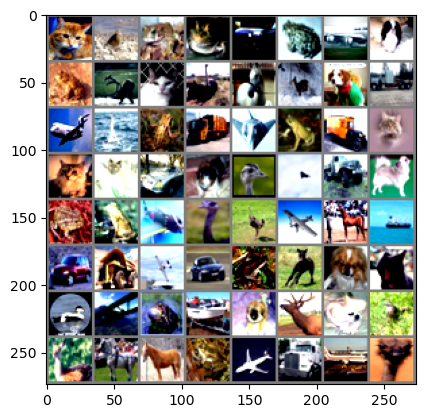

cat   bird  frog  frog  plane frog  plane dog   frog  deer  cat   bird  horse deer  dog   truck plane bird  frog  truck plane frog  truck cat   cat   cat   car   dog   bird  plane truck dog   frog  frog  plane bird  bird  plane horse ship  car   truck plane car   frog  horse dog   cat   bird  plane frog  ship  dog   deer  dog   bird  deer  horse horse frog  plane truck plane bird 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [64]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


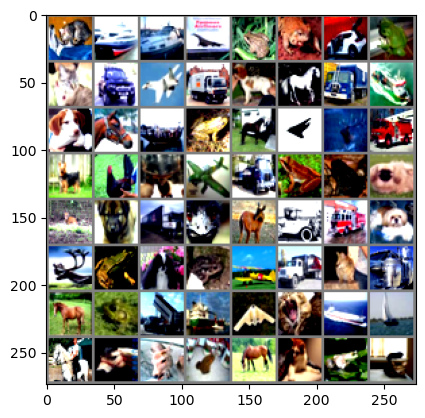

GroundTruth:  cat   ship  ship  plane


In [65]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [66]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


Predicted:  cat   frog  truck ship 


In [67]:
correct = 0
total = 0
net.to('cuda')
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 36 %


In [68]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 42.4 %
Accuracy for class: car   is 58.8 %
Accuracy for class: bird  is 3.1 %
Accuracy for class: cat   is 24.7 %
Accuracy for class: deer  is 7.2 %
Accuracy for class: dog   is 39.9 %
Accuracy for class: frog  is 61.1 %
Accuracy for class: horse is 52.6 %
Accuracy for class: ship  is 34.7 %
Accuracy for class: truck is 45.0 %


In [6]:
import torch

def compute_test_accuracy_and_loss(model, testloader, device, criterion):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            
            # Calculate the loss
            loss = criterion(outputs, labels)
            test_loss += loss.item() * labels.size(0)  # Accumulate the loss
            
            # Get predictions: choose class with highest score
            _, predicted = torch.max(outputs, 1)
            
            # Update total count and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute accuracy as a percentage
    accuracy = 100 * correct / total
    
    # Compute the average loss over all test data
    avg_test_loss = test_loss / total

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Test Loss: {avg_test_loss:.4f}')
    
    return accuracy, avg_test_loss


## Exercise 0
Find the correct mean and std of CIFAR10 dataset to normalize data correctly, i.e., to have data with mean 0 and std 1.

In [69]:
from  torchvision import datasets

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True  )
data = cifar_trainset.data / 255 # data is numpy array and images are in range 0-255

mean = data.mean(axis = (0,1,2)) 
std = data.std(axis = (0,1,2))
print(f"Mean : {mean}   STD: {std}")

#[0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784]

Files already downloaded and verified
Mean : [0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784]


### Exercise 1
Try to use a scheduler for the learning rate (https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

- What are the differences?
- Does it improves the training convergence/test accuracy?


## do it with multistep and cosine or look for plateaux

In [70]:
""" Example of usage
    >>> scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
    >>> for epoch in range(100):
    >>>     train(...)
    >>>     test(...)
    >>>     scheduler.step()
"""

from torch.optim.lr_scheduler import MultiStepLR

epochs = 10
model = Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[5,2001], gamma=0.1)

for epoch in range(epochs):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current learning rate: {current_lr}")
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
         # print statistics
        running_loss += loss.item()
        if i % 2000 == 100:    # print every 2000 mini-batches
#            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss}')

            running_loss = 0.0
    scheduler.step()

print('Finished Training')


Current learning rate: 0.01
[1,   101] loss: 1717.4218055009842
Current learning rate: 0.01
[2,   101] loss: 1251.5363095998764
Current learning rate: 0.01
[3,   101] loss: 1026.481580376625
Current learning rate: 0.01
[4,   101] loss: 925.6162597537041
Current learning rate: 0.01
[5,   101] loss: 848.8591241836548
Current learning rate: 0.001
[6,   101] loss: 791.2545557022095
Current learning rate: 0.001
[7,   101] loss: 638.6449149250984
Current learning rate: 0.001
[8,   101] loss: 608.7942116856575
Current learning rate: 0.001
[9,   101] loss: 596.5679459273815
Current learning rate: 0.001
[10,   101] loss: 575.2642564475536
Finished Training


Test Accuracy: 47.30%
Test Loss: 1.4370
Epoch [1/20], Train Loss: 1.7149, Test Loss: 1.4370, Test Accuracy: 47.30%
Test Accuracy: 55.49%
Test Loss: 1.2529
Epoch [2/20], Train Loss: 1.3320, Test Loss: 1.2529, Test Accuracy: 55.49%
Test Accuracy: 57.89%
Test Loss: 1.2083
Epoch [3/20], Train Loss: 1.1781, Test Loss: 1.2083, Test Accuracy: 57.89%
Test Accuracy: 60.70%
Test Loss: 1.1358
Epoch [4/20], Train Loss: 1.0878, Test Loss: 1.1358, Test Accuracy: 60.70%
Test Accuracy: 64.97%
Test Loss: 1.0111
Epoch [5/20], Train Loss: 0.8844, Test Loss: 1.0111, Test Accuracy: 64.97%
Test Accuracy: 65.32%
Test Loss: 1.0047
Epoch [6/20], Train Loss: 0.8435, Test Loss: 1.0047, Test Accuracy: 65.32%
Test Accuracy: 65.37%
Test Loss: 0.9982
Epoch [7/20], Train Loss: 0.8231, Test Loss: 0.9982, Test Accuracy: 65.37%
Test Accuracy: 65.43%
Test Loss: 1.0006
Epoch [8/20], Train Loss: 0.8033, Test Loss: 1.0006, Test Accuracy: 65.43%
Test Accuracy: 65.97%
Test Loss: 0.9950
Epoch [9/20], Train Loss: 0.7689, Test L

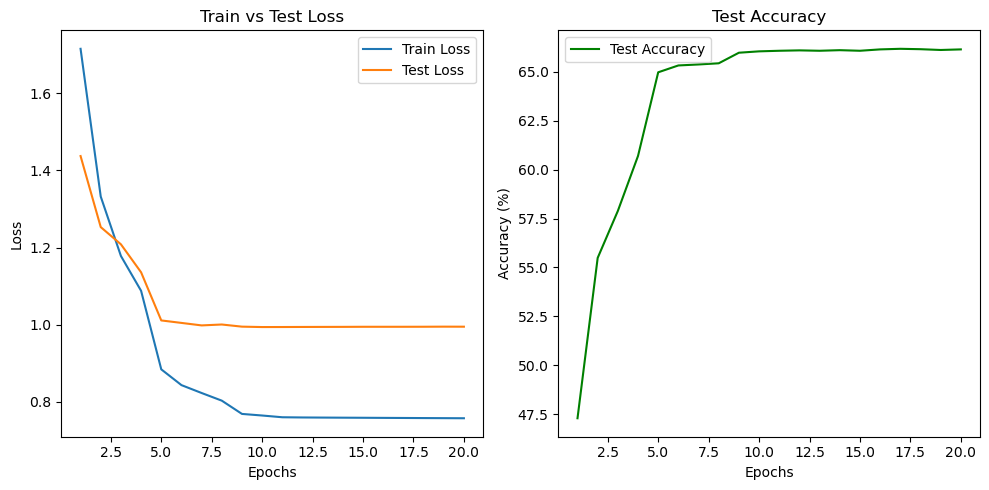

In [10]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt

# Assuming the compute_test_accuracy_and_loss function is already defined

# Initialize model, criterion, optimizer, and scheduler
model = Net()  # Your defined network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[4, 8,10, 14], gamma=0.1)

# Variables to track loss and accuracy
train_losses = []
test_losses = []
test_accuracies = []

# Number of epochs
num_epochs = 20

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()  # Set the model to training mode
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss.item() * labels.size(0)  # Accumulate training loss
    
    # Calculate average train loss for this epoch
    avg_train_loss = running_loss / len(trainloader.dataset)
    train_losses.append(avg_train_loss)
    
    # Compute test accuracy and test loss
    test_accuracy, test_loss = compute_test_accuracy_and_loss(model, testloader, device, criterion)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Step the scheduler
    scheduler.step()

    # Print statistics for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

print('Finished Training')

# Plotting
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))

# Plot train and test loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Exercise 2

Use some data augmentation to reduce overfitting.

All the transformations supported by PyTorch can be found at https://pytorch.org/vision/0.9/transforms.html#compositions-of-transforms

- Which transformations are the most impactfull on the accuracies?

Try to plot the effect of the transformations!

In [71]:
transform = transforms.Compose([
                        #train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),      # Randomly crop the image with padding
    transforms.RandomHorizontalFlip(),         # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jittering
    transforms.ToTensor(),                     # Convert image to PyTorch tensor
    #transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])  # Normalize with CIFAR-10 statistics
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)

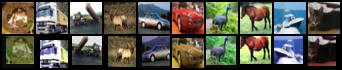

In [72]:
# plot real and augmented images
from torchvision.utils import make_grid
notransform = transforms.Compose([transforms.ToTensor()])
non_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, transform=notransform)

imgs = torch.stack((*[non_augmented[i][0] for i in range(10)],
                    *[trainset[i][0] for i in range(10)]))
grid = make_grid(imgs, nrow=10)

transforms.ToPILImage()(grid)

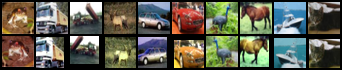

In [73]:
# plot real and augmented images
from torchvision.utils import make_grid
transform = transforms.Compose([transforms.ToTensor()])
non_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)

imgs = torch.stack((*[non_augmented[i][0] for i in range(10)],
                    *[trainset[i][0] for i in range(10)]))
grid = make_grid(imgs, nrow=10)

transforms.ToPILImage()(grid)

Now use it to train the your model

## Exercise 3
A) Try to change the network architecture (e.g. use all linear layers) or network hyperparameters (e.g. dimensions of the CNN kernel, stride, padding).

B) Try also to compare performance of your model with performance of pre-defined network architecture.
There are a lot of pre-defined network architectures (e.g. ResNet, VGG, AlexNet, ...).

Some example can be found in https://pytorch.org/vision/0.9/models.html.

Specific CIFAR10 architectures are also in this public repository https://github.com/kuangliu/pytorch-cifar.

In [74]:
import torchvision.models as models

alexnet = models.alexnet()
resnet18 = models.resnet18()
vgg16 = models.vgg16()